# Pytorch fully-connected neural network

## Imports

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# Training Parameters
num_steps = 2000 # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Stochastic Gradient Descent batch size

# NN Parameters
num_hidden1 = 2048 # Convolutional Kernel size
num_hidden2 = 1024 # Convolutional Kernel depth size == Number of Convolutional Kernels

# Optimization parameters
learning_rate = 0.001 # Learning rate

# Cuda
cuda = True # use GPU or not
device = torch.device('cuda' if cuda else 'cpu')

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

The image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = torch.tensor(data[:,0], dtype=torch.int64, device=device)
    values = torch.tensor(data[:,1:]/255, dtype=torch.float32, device=device)
    return values, labels
    
train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)

print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	torch.Size([50000, 784])
train labels shape:	torch.Size([50000])


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

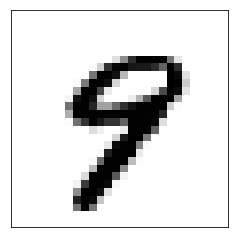

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.view(height, width).data.cpu().numpy(), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers. We use the `torch.nn.Module` to create the network.

We choose a 4 layered network consisting of 2 convolutional layers with kernel size `kernel_size` and depth `kernel_depth` and `2*kernel_depth` respectively. These convolutional layers are followed by two fully connected layers with `num_hidden` hidden neurons `num_labels` output nodes (one-hot encoding).

In [5]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # First Fully Connected Layer
        self.fc1 = torch.nn.Linear(
            in_features=num_pixels,
            out_features=num_hidden1,
        )
        # Second Fully Connected Layer
        self.fc2 = torch.nn.Linear(
            in_features=num_hidden1,
            out_features=num_hidden2,
        )
        # Third Fully Connected Layer
        self.fc3 = torch.nn.Linear(
            in_features=num_hidden2,
            out_features=num_labels,
        )
        # ReLU Activateion Layer
        self.relu = torch.nn.ReLU()
        # Softmax Activation Layer
        self.softmax = torch.nn.Softmax(dim=-1)
        
        # move to device:
        self.to(device)
        
    def forward(self, data):
        # first fully connected layer:
        x = self.relu(self.fc1(data))
        # second fully connected layer:
        x = self.relu(self.fc2(x))
        # third fully connected layer:
        logits = self.fc3(x)
        return logits
    

# Train

Create the model

In [6]:
model = Model()

We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp

In [7]:
# loss
lossfunc = torch.nn.CrossEntropyLoss()

# accuracy
def accuracy(logits, labels):
    return 100*np.mean(np.argmax(logits.data.cpu().numpy(), 1) == labels.data.cpu().numpy())

# optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

Run the session

In [8]:
%%time
history = [] 

for step in range(num_steps):
    # reset gradients
    optimizer.zero_grad()

    # calculate validation accuracy
    with torch.no_grad():
        if step%(train_size//batch_size) == 0 or step == num_steps - 1:
            valid_logits = model(valid_values)
            # get element of 0D array:
            valid_loss = lossfunc(valid_logits, valid_labels).item()
            valid_accuracy = accuracy(valid_logits, valid_labels)
            history.append((step, valid_loss, valid_accuracy))
            print(f'Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}')
    
    # train
    idxs = np.random.randint(0, train_size, batch_size)
    batch_values = train_values[idxs]
    batch_labels = train_labels[idxs]
    logits = model(batch_values)
    loss = lossfunc(logits, batch_labels)
    loss.backward()
    optimizer.step()

Step     0	 Valid. Acc. = 14.48
Step   500	 Valid. Acc. = 95.75
Step  1000	 Valid. Acc. = 97.32
Step  1500	 Valid. Acc. = 97.33
Step  1999	 Valid. Acc. = 97.83
CPU times: user 4.66 s, sys: 1.56 s, total: 6.21 s
Wall time: 6.23 s


Training history:

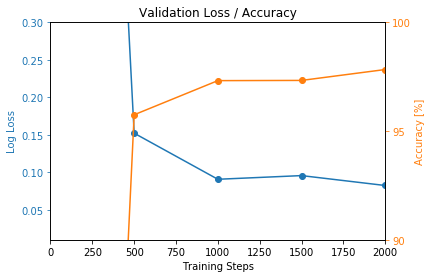

In [9]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(90,100)
plt.yticks([90,95,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
m = 1.1*max(loss)
plt.ylim(0.01, 0.3)

plt.xlim(0, (max(steps)+100)//100*100)
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

# Test

Finally, the accuracy on the test set can be evaluated:

In [10]:
with torch.no_grad():
    test_logits = model(test_values)
    test_accuracy = accuracy(test_logits, test_labels)
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 97.84


Visualize an example

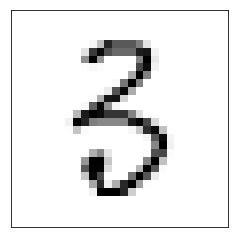

prediction=3	target=3


In [11]:
N = 315
show_digit(test_values[N])
test_logits = model(test_values[N:N+1])
prediction = torch.argmax(test_logits[0]).item()
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')